In [54]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [55]:
import talib as tl
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [56]:
filename = 'USDCLP.xlsx'
data = pd.read_excel(filename, skiprows=4, index_col='Dates', parse_dates=True)
data.dropna(inplace=True)
data.columns = ['Open', 'High', 'Low', 'Close']
data = data['2006-01':] # before 2004 the data is not OHLC, but C
data.head()
data['2018-01-08':'2018-01-13']

,Open,High,Low,Close
Dates,,,,
2018-01-08,606.37,608.47,604.58,605.31
2018-01-09,606.00,608.59,605.57,607.89
2018-01-10,607.66,610.70,606.23,609.32
2018-01-11,608.01,609.67,606.13,606.22
2018-01-12,603.17,605.81,602.86,603.18


In [57]:
train_size = 150
test_size = 50
return_day = 10
full_size = train_size + test_size + return_day
# make return_day long gap between train and test set to avoid lookahead bias

# rolling_std_dev_size = 40
extreme_multiplier = 0

In [58]:
new_data = data.resample('1W').pad()
new_data['Open'] = data['Open'].resample('1W').first()
new_data['Close'] = data['Close'].resample('1W').last()
new_data['High'] = data['High'].resample('1W').max()
new_data['Low'] = data['Low'].resample('1W').min()
new_data.dropna(inplace=True)
new_data.tail()

,Open,High,Low,Close
Dates,,,,
2018-01-07,612.19,612.45,601.80,605.78
2018-01-14,606.37,610.70,602.86,603.18
2018-01-21,599.58,608.82,599.31,608.21
2018-01-28,607.69,609.78,597.70,601.68
2018-02-04,603.65,607.37,596.31,597.03


In [59]:
data = new_data

In [60]:
oopen = data['Open'].values
high = data['High'].values
low = data['Low'].values
close = data['Close'].values

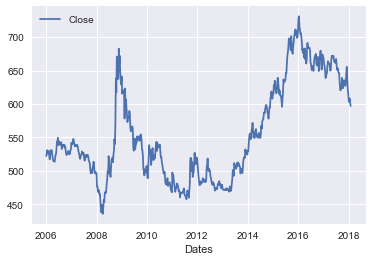

In [62]:
data['2006-01':][['Close']].plot()

In [8]:
features_to_delete = data.columns.tolist()

# ROC

In [9]:
for i in [2, 5, 10, 20, 30]:
    data[f'ROC {i}'] = tl.ROC(close, timeperiod=i)

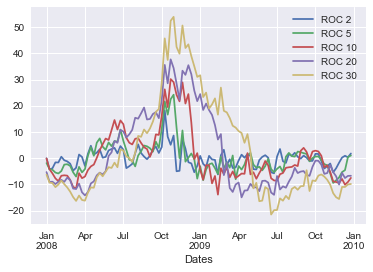

In [10]:
data['2008': '2009'][['ROC 2', 'ROC 5', 'ROC 10', 'ROC 20', 'ROC 30']].plot()

# Deviation from zero-lag exponential MA

In [11]:
for i in [10, 20, 40]:
    lag = (i-1)/2
    ema_data = 2*data['Close'] - data['Close'].shift(i).fillna(method='bfill')
    data['Deviation EMA ' + str(i)] = data['Close'] - tl.EMA(ema_data.values, timeperiod=i)

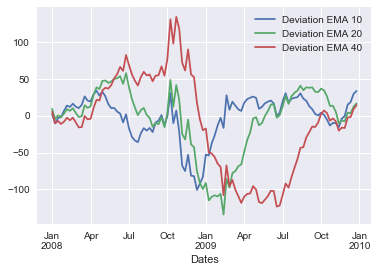

In [12]:
data['2008':'2009'][['Deviation EMA 10', 'Deviation EMA 20', 'Deviation EMA 40']].plot()

# MACD

In [13]:
for i, j, k in [(14, 20, 12), (12, 16, 9), (3, 5, 2)]:
    macd, macdsignal, macdhist = tl.MACD(close, fastperiod=i, slowperiod=j, signalperiod=k)
    data[f'MACD ({i}, {j}, {k})'] = macd

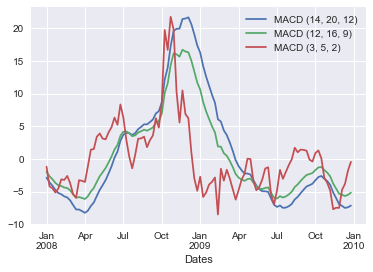

In [14]:
data['2008':'2009'][['MACD (14, 20, 12)', 'MACD (12, 16, 9)', 'MACD (3, 5, 2)']].plot()

# RSI

In [15]:
for i in [5, 10, 14, 20]:
    data[f'RSI {i}'] = tl.RSI(close, timeperiod=i)

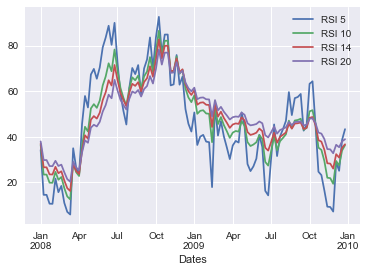

In [16]:
data['2008':'2009'][['RSI 5', 'RSI 10', 'RSI 14', 'RSI 20']].plot()

# SMA differences

In [17]:
for i, j in [(5, 10), (10, 20), (20, 40)]:
    data[f'SMA ({i}, {j}) diff'] = tl.SMA(close, timeperiod=i) - tl.SMA(close, timeperiod=j)

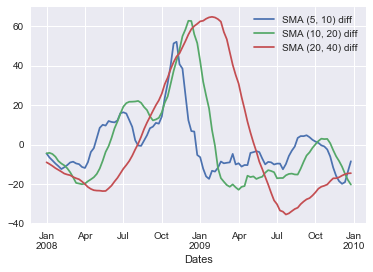

In [18]:
data['2008':'2009'][['SMA (5, 10) diff', 'SMA (10, 20) diff', 'SMA (20, 40) diff']].plot()

# ADX: Average directional index

In [19]:
data['ADX 20'] = tl.ADX(high, low, close, timeperiod=20)
data['ADX 14'] = tl.ADX(high, low, close, timeperiod=14)
data['ADX 7'] = tl.ADX(high, low, close, timeperiod=7)

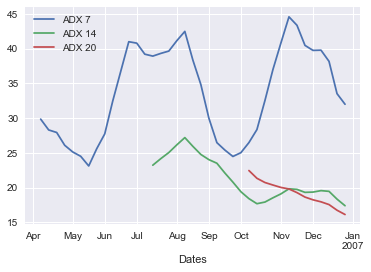

In [20]:
data['2005':'2006'][['ADX 7', 'ADX 14', 'ADX 20']].plot()

# CCI: Commodity Channel Index

In [21]:
data['CCI 14'] = tl.CCI(high, low, close, timeperiod=14)

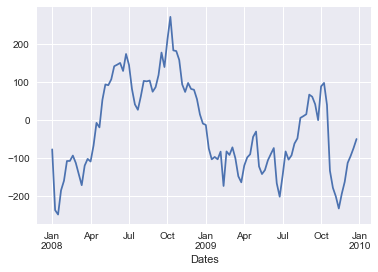

In [22]:
data['2008':'2009']['CCI 14'].plot()

# STD deviation 20 = Bollinger Bands (20)

In [23]:
data['Std dev 10'] = tl.STDDEV(close, timeperiod=10)
data['Std dev 20'] = tl.STDDEV(close, timeperiod=20)

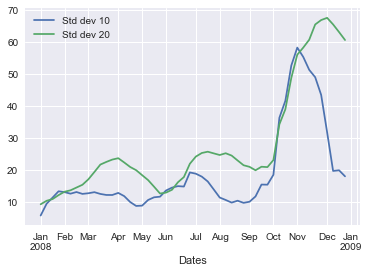

In [24]:
data['2008'][['Std dev 10', 'Std dev 20']].plot()

# Y target value

In [25]:
data['Return'] = data['Close'].pct_change(return_day).shift(-return_day)*100
data['Return scaled'] = data['Return'] / (data['Return'].rolling(return_day).std().fillna(1.0))

In [26]:
data.dropna(inplace=True)
data.drop(labels=features_to_delete, inplace=True, axis=1)
data.head()

,ROC 2,ROC 5,ROC 10,ROC 20,ROC 30,Deviation EMA 10,Deviation EMA 20,Deviation EMA 40,"MACD (14, 20, 12)","MACD (12, 16, 9)",...,"SMA (10, 20) diff","SMA (20, 40) diff",ADX 20,ADX 14,ADX 7,CCI 14,Std dev 10,Std dev 20,Return,Return scaled
Dates,,,,,,,,,,,,,,,,,,,,,
2006-10-08,-0.380228,-0.158007,-0.380228,2.519565,1.177357,-0.121162,-14.330774,-2.643500,0.863213,0.499993,...,-0.7925,7.88075,22.459781,18.420776,26.475325,-77.651909,2.891914,5.154992,-2.178365,-4.622072
2006-10-15,-0.659776,-1.433526,-2.018619,1.257382,0.710564,-2.690042,-18.661177,-8.292598,0.561771,0.224931,...,-2.2175,7.97950,21.345071,17.692026,28.352164,-123.336829,3.097586,4.406573,-0.047037,-0.058278
2006-10-22,-2.075964,-2.094192,-3.095348,-1.137218,-0.962226,-3.687307,-21.329160,-13.177105,0.106841,-0.185409,...,-3.5950,7.67200,20.738684,17.927916,32.522445,-203.482817,3.955128,5.051440,1.216846,1.036234
2006-10-29,-1.467545,-2.865622,-1.696888,-3.687356,-0.503467,-3.214160,-19.424002,-14.316027,-0.336954,-0.569863,...,-3.4965,6.85325,20.375245,18.539290,36.989996,-218.790097,5.257808,5.907448,3.488639,1.784633
2006-11-05,-0.066546,-1.762518,-2.168450,-3.417861,0.970128,1.042960,-14.083621,-11.785977,-0.608285,-0.777806,...,-3.7315,5.93575,20.029978,19.106994,40.819325,-151.857612,5.764811,6.294258,2.612253,1.188911


# Features

In [27]:
feature_names = data.drop(['Return', 'Return scaled'], axis=1).columns

# Train and test Random Forest

In [28]:
def to_class(y_vec):
#     y_extreme = extreme_multiplier * y_vec.rolling(rolling_std_dev_size).std().fillna(method='bfill')
    
    pos = y_vec > extreme_multiplier
    neg = y_vec < -1*extreme_multiplier

    y_vec[:] = 'Neutral'
    y_vec[pos] = 'Pos'
    y_vec[neg] = 'Neg'
    return y_vec

In [29]:
def make_X_y(df):
    X = df.drop(['Return', 'Return scaled'], axis=1)
    y = df['Return'].copy()
    ret = y.copy()
    y = to_class(y)
    return X, y, ret

In [30]:
def split_X_y(X, y, ret):
    X_train = X.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[train_size:]
    ret = ret.iloc[train_size:]
    
    last_q4 = int(train_size/4)
    last_q8 = int(train_size/8)
    last_q16 = int(train_size/16)
    X_train = pd.concat([X_train, X_train[-last_q4:], X_train[-last_q8:], X_train[-last_q16:]], ignore_index=True)
    y_train = pd.concat([y_train, y_train[-last_q4:], y_train[-last_q8:], y_train[-last_q16:]], ignore_index=True)
    return X_train, X_test, y_train, y_test, ret

In [31]:
def print_labels_distrib(y_train, y_test):
    def distrib_print(vec):
        print('---\nDistribution:\n' + str(vec.value_counts()))
        
    distrib_print(y_train)
    distrib_print(y_test)

In [32]:
from sklearn.metrics import make_scorer
def custom_loss(y_true, y_pred):
    bad = ((y_true == 'Pos') & (y_pred == 'Neg')) | ((y_true == 'Neg') & (y_pred == 'Pos'))
    bad_sum = -20*np.sum(bad)
    avg = ((y_true == 'Neutral') & (y_pred == 'Pos')) | ((y_true == 'Neutral') & (y_pred == 'Neg'))
    avg_sum = -2*np.sum(avg)
    good = ((y_true == 'Pos') & (y_pred == 'Pos')) | ((y_true == 'Neg') & (y_pred == 'Neg'))
    good_sum = 7*np.sum(good)
    return bad_sum + good_sum
scorer = make_scorer(custom_loss, greater_is_better=True)

In [33]:
def calculate_returns(ret, y_pred):
    longs = np.nansum(ret[y_pred == 'Pos'])
    shorts = np.nansum(-1*ret[y_pred == 'Neg'])
    ret_sum = longs + shorts
    print(f'{longs} [long] + {shorts} [short] = {ret_sum}')
    return ret_sum

In [34]:
def print_results(y_test, y_pred):
    print('---\nClassification report\n', classification_report(y_test, y_pred))
    print('---\nConfusion matrix\n', str(confusion_matrix(y_test, y_pred)))

# Train and Test

In [35]:
def train_and_test(df):
    X, y, ret = make_X_y(df)
    X_train, X_test, y_train, y_test, ret = split_X_y(X, y, ret)
    print_labels_distrib(y_train, y_test)
    
    forest = RandomForestClassifier(n_jobs=8, class_weight='balanced_subsample')
    pipe = Pipeline(steps=[('scaler', StandardScaler()), 
#                            ('pca', PCA()), 
                           ('forest', forest)])
    
    params = {'forest__n_estimators': [50],
              'forest__max_depth': [4],
              'forest__max_features': [3,4],
              'forest__min_samples_split': [2,3,4],
              'forest__min_samples_leaf': [2,3],
#               'pca__n_components': [0.3, 0.7]
             }
    grid = GridSearchCV(estimator=pipe,
                        param_grid=params, 
                        scoring=scorer,
                        cv=6)
    
    grid.fit(X_train, y_train)
    best_estimator = grid.best_estimator_
    best_params = grid.best_params_
    
    y_pred = best_estimator.predict(X_test)
    print_results(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    ret_sum = calculate_returns(ret, y_pred)
    
    param = {
        'accuracy':acc,
        'date': df.index[-1],
        'best_params': best_params,
        'features': best_estimator.steps[-1][1].feature_importances_,
        'ret_sum': ret_sum
    }
    test_params.append(param)

In [36]:
test_params = []

for i in range(0, len(data)-full_size, test_size):
    sub_data = data.iloc[i:i+full_size]
    from_date, to_date = sub_data.index[0], sub_data.index[-1] #mit jelent az index[-1]?
    sep = 100*'='
    print(f'{sep}\nFrom {from_date} to {to_date}')
    train_and_test(sub_data)

From 2006-10-08 00:00:00 to 2010-10-10 00:00:00
---
Distribution:
Neg    138
Pos     76
Name: Return, dtype: int64
---
Distribution:
Neg    39
Pos    21
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.85      0.87      0.86        39
        Pos       0.75      0.71      0.73        21

avg / total       0.81      0.82      0.82        60

---
Confusion matrix
 [[34  5]
 [ 6 15]]
53.05446575849216 [long] + 174.59941352061952 [short] = 227.65387927911166
From 2007-09-23 00:00:00 to 2011-09-25 00:00:00
---
Distribution:
Neg    126
Pos     88
Name: Return, dtype: int64
---
Distribution:
Neg    36
Pos    24
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.62      0.89      0.73        36
        Pos       0.50      0.17      0.25        24

avg / total       0.57      0.60      0.54        60

---
Confusion matrix
 [[32  4]
 [20  4]]

In [37]:
indexes = [d['date'] for d in test_params]

# Random Forest parameters with Accuracy and Returns

In [38]:
params = pd.DataFrame([d['best_params'] for d in test_params], index=indexes)
params['Sum of return'] = [d['ret_sum'] for d in test_params]
params['Accuracy'] = [d['accuracy'] for d in test_params]

In [39]:
params.sort_values('Sum of return', ascending=False)

,forest__max_depth,forest__max_features,forest__min_samples_leaf,forest__min_samples_split,forest__n_estimators,Sum of return,Accuracy
2010-10-10,4,3,3,3,50,227.653879,0.816667
2015-07-26,4,3,3,2,50,202.025712,0.800000
2013-08-25,4,4,3,3,50,65.411934,0.600000
2016-07-10,4,4,2,4,50,43.036441,0.483333
2012-09-09,4,3,3,4,50,37.941783,0.566667
2011-09-25,4,4,2,3,50,-31.043161,0.600000
2017-06-25,4,4,2,3,50,-33.993739,0.533333
2014-08-10,4,4,3,3,50,-73.173770,0.366667


In [40]:
params.describe()

,forest__max_depth,forest__max_features,forest__min_samples_leaf,forest__min_samples_split,forest__n_estimators,Sum of return,Accuracy
count,8.0,8.000000,8.000000,8.00000,8.0,8.000000,8.000000
mean,4.0,3.625000,2.625000,3.12500,50.0,54.732385,0.595833
std,0.0,0.517549,0.517549,0.64087,0.0,109.361585,0.151383
min,4.0,3.000000,2.000000,2.00000,50.0,-73.173770,0.366667
25%,4.0,3.000000,2.000000,3.00000,50.0,-31.780806,0.520833
50%,4.0,4.000000,3.000000,3.00000,50.0,40.489112,0.583333
75%,4.0,4.000000,3.000000,3.25000,50.0,99.565379,0.650000
max,4.0,4.000000,3.000000,4.00000,50.0,227.653879,0.816667


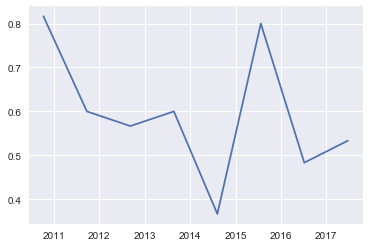

In [41]:
params['Accuracy'].plot()

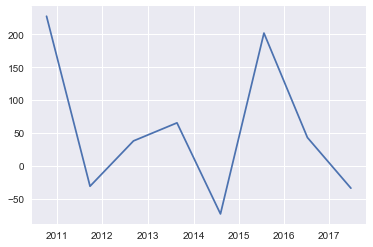

In [42]:
params['Sum of return'].plot()

In [43]:
features = pd.DataFrame([d['features'] for d in test_params], index=indexes, columns=feature_names)

In [44]:
features.idxmax(axis=1).value_counts()

SMA (10, 20) diff    2
Std dev 20           2
MACD (12, 16, 9)     1
MACD (14, 20, 12)    1
SMA (20, 40) diff    1
ADX 20               1
dtype: int64

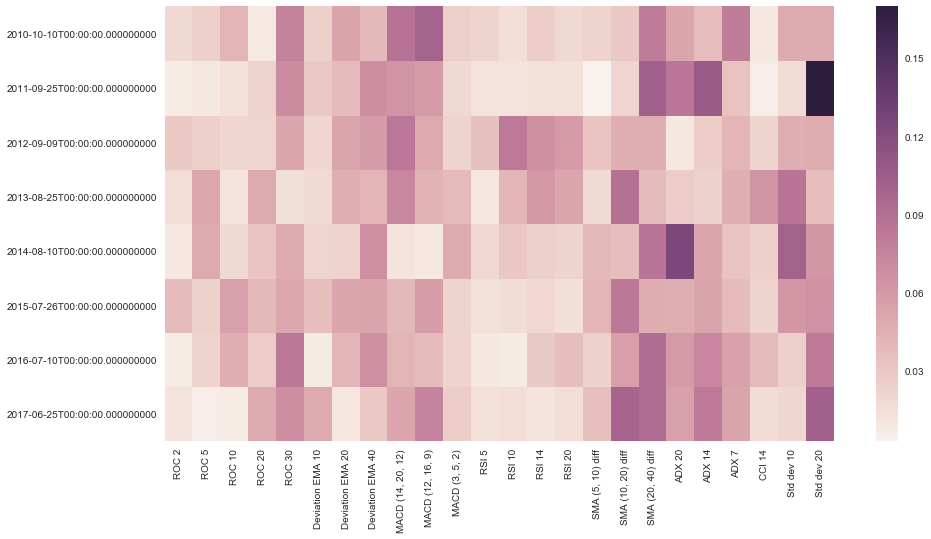

In [45]:
plt.figure(figsize=(15,8))
sns.heatmap(features)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


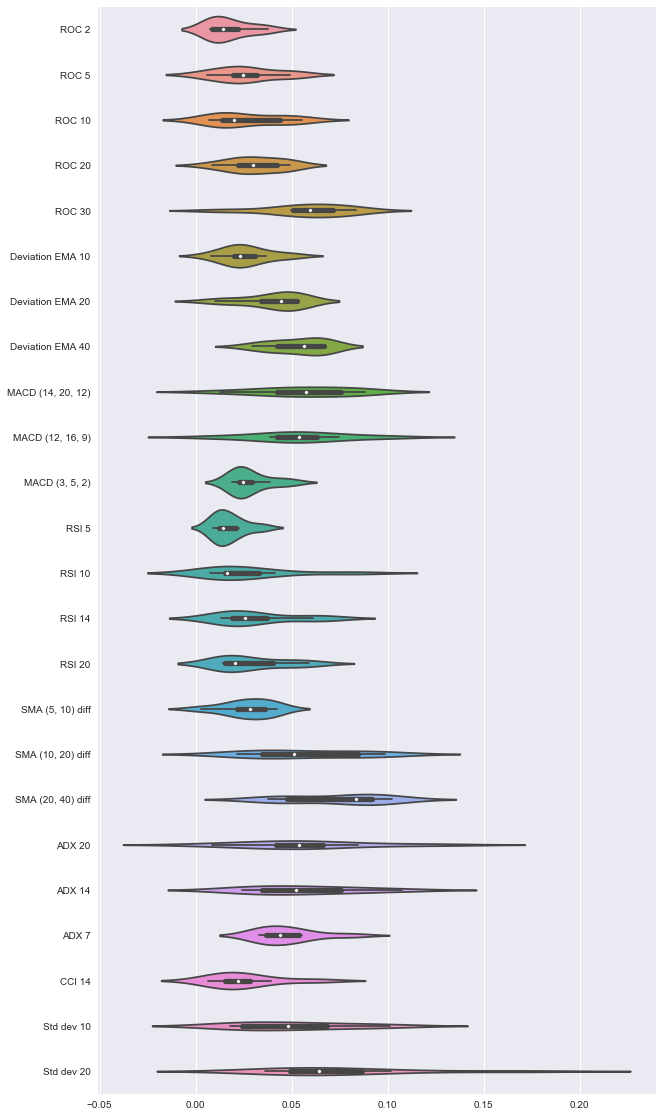

In [46]:
plt.figure(figsize=(10,20))
sns.violinplot(data=features, orient='h')